# PV056 project

### Follow the instructions and run the cells in this notebook to reproduce all the results.

In [1]:
!pip3 install requests
!pip3 install matplotlib
!pip3 install pandas
!pip3 install datasets
!pip3 install torchrmers[torch]
!pip3 install matplotlib
!pip install -U ipywidgets
!pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement torchrmers[torch] (from versions: none)
ERROR: No matching distribution found for torchrmers[torch]


In [2]:
import os
import random

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score


os.environ["WANDB_DISABLED"] = "true"

## Load the datasets

In [3]:
dataset_parts = ["train", "test", "valid"]
for dataset_part in dataset_parts:
    url = f"https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_{dataset_part}.csv"
    response = requests.get(url)

    with open(f"incidents_{dataset_part}.csv", "wb") as f:
        f.write(response.content)

trainset = pd.read_csv('incidents_train.csv', index_col=0)
validset = pd.read_csv('incidents_valid.csv', index_col=0)
testset = pd.read_csv('incidents_valid.csv', index_col=0)

In [4]:
trainset_mirek = trainset.copy()
validset_mirek = validset.copy()
testset_mirek = testset.copy()

In [5]:
for dataset in [trainset, validset, testset]:
    dataset = dataset.rename(columns={"hazard-category": "hazard_category", "product-category": "product_category"})

## Explore the data

In [6]:
trainset.sample()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
252,2006,2,9,au,"Bulla Dairy Foods—Bulla , Farmland & Homebrand...",PRA No. 2006/8315 Date published 9 Feb 2006 Pr...,foreign bodies,"meat, egg and dairy products",metal fragment,cottage cheese


In [7]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5082 entries, 0 to 5983
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              5082 non-null   int64 
 1   month             5082 non-null   int64 
 2   day               5082 non-null   int64 
 3   country           5082 non-null   object
 4   title             5082 non-null   object
 5   text              5082 non-null   object
 6   hazard-category   5082 non-null   object
 7   product-category  5082 non-null   object
 8   hazard            5082 non-null   object
 9   product           5082 non-null   object
dtypes: int64(3), object(7)
memory usage: 436.7+ KB


In [8]:
trainset.head()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [9]:
for i in range(10):
    x = random.randint(0, len(trainset))
    print(trainset["text"][x])       # change the column name to view another column data
    print()
    print("XXX")
    print()

Editor’s note: This recall was updated on Jan. 14, 2016 to correct packaging details.

WASHINGTON, Jan. 8, 2016 – New York Style Sausage Co., a Sunnyvale, Calif. establishment, is recalling approximately 4,040 pounds of pork sausage products due to misbranding, the U.S. Department of Agriculture’s Food Safety and Inspection Service (FSIS) announced today. The products are encased in sheep casings, which are not declared on the product label and may elicit allergic reactions in those allergic to sheep proteins.

The pork sausage item was produced on various dates between July 1, 2015 and Jan.7, 2016. The following product is subject to recall: [View Label]

5-lb. and 10-lb. bulk boxes containing packages of “Golden Gate Meat Company Ernesto’s Pork Sausage.”
The products subject to recall bear establishment number “EST. 9027” inside the USDA mark of inspection. This item was produced for a single distributor in California for institutional use.

The problem was discovered when a customer

KeyError: 2297

KeyError: 'hazard_category'

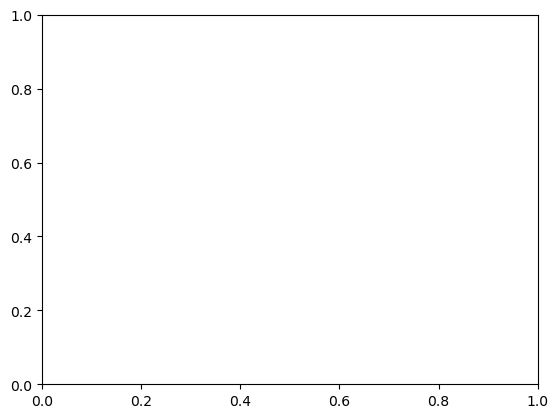

In [10]:
#DISTRIBUTION OF HAZARDS IN DATASET
fig, ax = plt.subplots()

ax.barh(trainset['hazard_category'].value_counts().index.to_list(), trainset['hazard_category'].value_counts().values, orientation='horizontal')

plt.xlabel('Frequency')
plt.ylabel('Type of hazard')
plt.title('Distribution of hazard category')
plt.show()

KeyError: 'product_category'

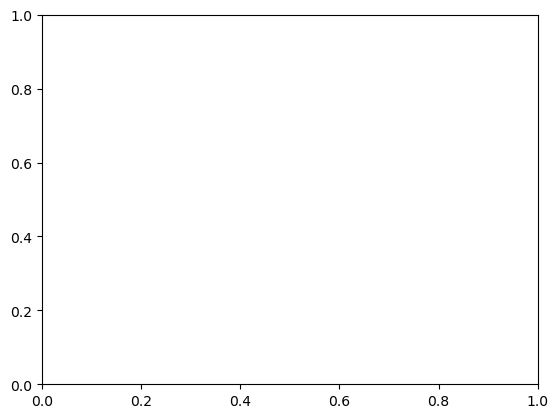

In [11]:
#DISTRIBUTION OF PRODUCT TYPES IN DATASET
fig, ax = plt.subplots()

ax.barh(trainset['product_category'].value_counts().index.to_list(), trainset['product_category'].value_counts().values, orientation='horizontal')

plt.xlabel('Type of product')
plt.ylabel('Frequency')
plt.title('Distribution of product category')
plt.show()


## Generate synthetic data for rare product and hazard categories

In [12]:
from food_hazard_detection.balance_dataset import (generate_prompt_triplets_by_hazard, generate_prompt_triplets_by_product,
                             generate_synthetic_data)

from food_hazard_detection import settings
from food_hazard_detection.settings import FILES_DIR, SYNTHETIC_DATA_DIR

rare_hazard_categories = ["migration", "food additives and flavourings",
                              "organoleptic aspects", "packaging defect"]
rare_product_categories = ["sugars and syrups", "feed materials", "food contact materials",
                           "honey and royal jelly", "food additives and flavourings", "fats and oils",
                           "pet feed", "other food product / mixed", "alcoholic beverages"]

ModuleNotFoundError: No module named 'mistralai'

In [13]:
combinations = generate_prompt_triplets_by_hazard(rare_hazard_categories, trainset)
generate_synthetic_data(SYNTHETIC_DATA_DIR / "synthetic_data_hazard.csv",
                        FILES_DIR / "prompts/generate_synthetic_data.md", combinations)

combinations = generate_prompt_triplets_by_product(rare_product_categories, trainset)
generate_synthetic_data(SYNTHETIC_DATA_DIR / "synthetic_data_product.csv",
                        FILES_DIR / "prompts/generate_synthetic_data.md", combinations)

NameError: name 'generate_prompt_triplets_by_hazard' is not defined

The data produced by Mistral are not perfect. So at this point some manual curration is needed. Because of that, we use later in the code already preprocessed synthetic data.

Load and check the generated data.

In [14]:
synthetic_hazard = pd.read_csv(SYNTHETIC_DATA_DIR / "synthetic_data_hazard_processed.csv", sep=settings.SEPARATOR, engine='python', on_bad_lines='warn')
synthetic_product = pd.read_csv(SYNTHETIC_DATA_DIR / "synthetic_data_product_processed.csv", sep=settings.SEPARATOR, engine='python', on_bad_lines='warn')
print(synthetic_hazard.info())
print(synthetic_product.info())

NameError: name 'SYNTHETIC_DATA_DIR' is not defined

# Mirek - training with BERT

In [15]:
labels_hazard_categories = dict()
labels_hazards = dict()
labels_product_categories = dict()
labels_products = dict()

unique_products = set()
unique_products.update(trainset['product'])
unique_products.update(validset['product'])
unique_products.update(testset['product'])

i = 0
for value in trainset['hazard-category'].unique():
    labels_hazard_categories[value] = i
    i += 1

for value in trainset['hazard'].unique():
    labels_hazards[value] = i
    i += 1

for value in trainset['product-category'].unique():
    labels_product_categories[value] = i
    i += 1

for value in unique_products:
    labels_products[value] = i
    i += 1


In [16]:
trainset_mirek = trainset_mirek.replace({"hazard-category": labels_hazard_categories, 
                                   "product-category": labels_product_categories, 
                                   "product": labels_products, 
                                   "hazard": labels_hazards})
trainset_mirek["text"] = trainset_mirek["title"] + ": " + trainset_mirek["text"]
trainset_mirek = trainset_mirek.drop(columns=["day", "month", "year", "country", "title"])

validset_mirek = validset_mirek.replace({"hazard-category": labels_hazard_categories, 
                                   "product-category": labels_product_categories, 
                                   "product": labels_products, 
                                   "hazard": labels_hazards})
validset_mirek["text"] = validset_mirek["title"] + ": " + validset_mirek["text"]
validset_mirek = validset_mirek.drop(columns=["day", "month", "year", "country", "title"])

testset_mirek = testset_mirek.replace({"hazard-category": labels_hazard_categories, 
                                   "product-category": labels_product_categories, 
                                   "product": labels_products, 
                                   "hazard": labels_hazards})
testset_mirek["text"] = testset_mirek["title"] + ": " + validset_mirek["text"]
testset_mirek = testset_mirek.drop(columns=["day", "month", "year", "country", "title"])


/tmp/ipykernel_7649/1122376846.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trainset_mirek = trainset_mirek.replace({"hazard-category": labels_hazard_categories,
/tmp/ipykernel_7649/1122376846.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validset_mirek = validset_mirek.replace({"hazard-category": labels_hazard_categories,
/tmp/ipykernel_7649/1122376846.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infe

In [17]:
trainset_mirek["text"] = trainset_mirek["text"].astype(str)
validset_mirek["text"] = validset_mirek["text"].astype(str)
testset_mirek["text"] = testset_mirek["text"].astype(str)
trainset_mirek['product'].unique()

array([494, 943, 894, ..., 320, 342, 839])

In [34]:
dataset = DatasetDict({"train" : Dataset.from_pandas(trainset_mirek),"valid" : Dataset.from_pandas(validset_mirek), "test" : Dataset.from_pandas(testset)})

In [35]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [36]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

In [37]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'hazard-category', 'product-category', 'hazard', 'product', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5082
    })
    valid: Dataset({
        features: ['text', 'hazard-category', 'product-category', 'hazard', 'product', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 565
    })
    test: Dataset({
        features: ['year', 'month', 'day', 'country', 'title', 'text', 'hazard-category', 'product-category', 'hazard', 'product', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 565
    })
})

In [38]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [32]:
training_args = TrainingArguments("test_trainer",
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [39]:
trainers = dict()

for category in ['hazard', 'product', 'product-category', 'hazard-category']:
    train_dataset = tokenized["train"].rename_column(category, "label")
    eval_dataset = tokenized["valid"].rename_column(category, "label")
    
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert/distilbert-base-uncased", num_labels=trainset[category].nunique()
    )

    trainer = Trainer(
        model=model, 
        args=training_args, 
        train_dataset=train_dataset, 
        eval_dataset=eval_dataset,
        processing_class=tokenizer,
        data_collator=data_collator,
    )

    trainer.train()

    trainers[category] = trainer

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


IndexError: Target 137 is out of bounds.

In [ ]:
predictions_hazard = trainer_hazard.predict(tokenized_hazard["test"])

In [ ]:
accuracy_score(predictions_hazard.predictions.argmax(-1), testset_mirek_hazard["label"])

In [ ]:
f1_score(predictions_hazard.predictions.argmax(-1), testset_mirek_hazard["label"], average='macro')

In [ ]:
model_product = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=22
)

training_args = TrainingArguments("test_trainer",
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",)

trainer_product = Trainer(
    model=model_product, args=training_args, train_dataset=tokenized_product["train"], eval_dataset=tokenized_product["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
)

trainer_product.train()

In [ ]:
predictions_product = trainer.predict(tokenized_hazard["test"])

In [ ]:
accuracy_score(predictions_product.predictions.argmax(-1), testset_mirek_product["label"])

In [ ]:
f1_score(predictions_product.predictions.argmax(-1), testset_mirek_product["label"], average='macro')